In [1]:
import random
import pandas as pd
import os

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from PIL import Image, ImageFilter

import keras.backend as KerasBackend

from skimage.transform import resize

import time
import numpy
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
import keras
import cv2

import tensorflow as tf
import keras.utils as np_utils


import tqdm

from keras.preprocessing import image
from keras.layers import Lambda
from keras.layers import Concatenate

from keras.callbacks import EarlyStopping
from tqdm import tqdm_notebook as tqdm_NB
import os
import shutil

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import re
from keras.preprocessing.image import ImageDataGenerator

from IPython.core.display import display, HTML


import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

c:\users\buckf\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_train = 'data/train/'
path_test = 'data/test/'

train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [3]:
im_height = 128
im_width = 128
im_chan = 1

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_NB(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = image.load_img(path + '/images/' + id_)
    x = image.img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = image.img_to_array(image.load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 



Done!


In [4]:
#Attempting to Augment X_Train and y_train images.
#Here is a link to the library Documentation:
display(HTML("""<a href="https://augmentor.readthedocs.io/en/master/">Documentation</a>"""))
#I am using an tutorial found here: 
display(HTML("""<a href="https://github.com/mdbloice/Augmentor">Tutorial</a>"""))
import Augmentor

## Image Augmentation:

In [5]:
train_image_path = r"C:\Users\buckf\Documents\Practicum_2\Salt_Deposit_Identification-master\data\train\images"

train_mask_path = r"C:\Users\buckf\Documents\Practicum_2\Salt_Deposit_Identification-master\data\train\masks"

p = Augmentor.Pipeline(train_image_path)
# Point to a directory containing ground truth data.
# Images with the same file names will be added as ground truth data
# and augmented in parallel to the original data.
p.ground_truth(train_mask_path)
# Add operations to the pipeline as normal:
p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
p.flip_left_right(probability=0.5)
p.zoom_random(probability=0.5, percentage_area=0.8)
p.flip_top_bottom(probability=0.5)

#This function allows you to select how many images you would like to augment.
p.sample(10)

Initialised with 4000 image(s) found.
Output directory set to C:\Users\buckf\Documents\Practicum_2\Salt_Deposit_Identification-master\data\train\images\output.

4000 ground truth image(s) found.


Processing <PIL.Image.Image image mode=RGB size=101x101 at 0x25B1576B978>: 100%|█| 10/10 [00:00<00:00, 147.45 Samples/s]


In [6]:
#All the orginal images being with "images_original_"
#All masks begin with "_groudtruth_(1)_images"

In [7]:
#This takes all the augmentated images and masks and creates places them
# in a two seperate folders into the train directory.

srcpath = r"C:\Users\buckf\Documents\Practicum_2\Salt_Deposit_Identification-master\data\train\images\output"
destpath = r"C:\Users\buckf\Documents\Practicum_2\Salt_Deposit_Identification-master\data\train"

for root, subFolders, files in os.walk(srcpath):
    for file in files:
        subFolder = os.path.join(destpath, file[:8])
        if not os.path.isdir(subFolder):
            os.makedirs(subFolder)
        shutil.move(os.path.join(root, file), subFolder)

In [8]:
#Renames files in train directory for ease.

#Augmented_Masks:
os.rename(src = r"C:\Users\buckf\Documents\Practicum_2\Salt_Deposit_Identification-master\data\train\_groundt", dst=r"C:\Users\buckf\Documents\Practicum_2\Salt_Deposit_Identification-master\data\train\aug_masks")

#Augmented_Images:
os.rename(src = r"C:\Users\buckf\Documents\Practicum_2\Salt_Deposit_Identification-master\data\train\images_o", dst=r"C:\Users\buckf\Documents\Practicum_2\Salt_Deposit_Identification-master\data\train\aug_images")

## Import Augmented Images

In [14]:
path_train

'data/train/'

In [27]:
aug_train_images_ids = next(os.walk(path_train+"aug_images"))[2]
aug_train_masks_ids = next(os.walk(path_train+"aug_masks"))[2]

In [ ]:
im_height = 128
im_width = 128
im_chan = 1

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_NB(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = image.load_img(path + '/images/' + id_)
    x = image.img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = image.img_to_array(image.load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

In [39]:
im_height = 128
im_width = 128
im_chan = 1

# Get and resize train images and masks
Aug_X_train = np.zeros((len(aug_train_images_ids), im_height, im_width, im_chan), dtype=np.uint8)
Aug_Y_train = np.zeros((len(aug_train_images_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_NB(enumerate(aug_train_images_ids), total=len(aug_train_images_ids)):
    path = path_train
    img = image.load_img(path + 'aug_images/' + id_)
    x = image.img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    Aug_X_train[n] = x
    
for n, id_ in tqdm_NB(enumerate(aug_train_masks_ids), total=len(aug_train_masks_ids)):    
    mask = image.img_to_array(image.load_img(path + 'aug_masks/' + id_))[:,:,1]
    Aug_Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 



Done!


In [51]:
Aug_Y_train.shape

(10, 128, 128, 1)

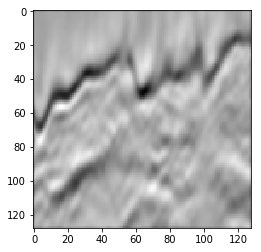

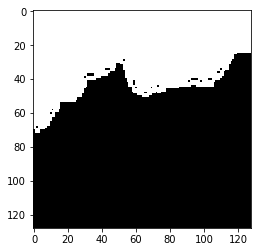

In [62]:
# Check if training data looks all right
ix = random.randint(0, len(Aug_X_train))
plt.imshow(np.dstack((Aug_X_train[ix],Aug_X_train[ix],Aug_X_train[ix])))
plt.show()


tmp = np.squeeze(Aug_Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [95]:
X_train.shape

(4000, 128, 128, 1)

In [96]:
Aug_X_train.shape

(10, 128, 128, 1)

In [100]:
X_Train_trial = np.concatenate((X_train, Aug_X_train), axis=3)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [105]:
c = concatenate((X_train[None,:,:,:],Aug_X_train[None,:,:,:]), axis=0)

ValueError: Layer concatenate_1 was called with an input that isn't a symbolic tensor. Received type: <class 'tuple'>. Full input: [(array([[[[[135],
          [149],
          [148],
          ...,
          [133],
          [134],
          [120]],

         [[151],
          [168],
          [167],
          ...,
          [152],
          [153],
          [137]],

         [[151],
          [168],
          [167],
          ...,
          [156],
          [158],
          [142]],

         ...,

         [[133],
          [150],
          [151],
          ...,
          [130],
          [122],
          [103]],

         [[135],
          [153],
          [154],
          ...,
          [130],
          [122],
          [103]],

         [[122],
          [138],
          [139],
          ...,
          [116],
          [109],
          [ 92]]],


        [[[ 43],
          [ 58],
          [ 74],
          ...,
          [108],
          [ 77],
          [ 50]],

         [[ 51],
          [ 69],
          [ 87],
          ...,
          [115],
          [ 82],
          [ 53]],

         [[ 58],
          [ 75],
          [ 93],
          ...,
          [108],
          [ 79],
          [ 52]],

         ...,

         [[ 94],
          [112],
          [118],
          ...,
          [122],
          [123],
          [115]],

         [[ 94],
          [111],
          [119],
          ...,
          [124],
          [124],
          [114]],

         [[ 84],
          [ 99],
          [109],
          ...,
          [112],
          [111],
          [101]]],


        [[[ 68],
          [ 76],
          [ 76],
          ...,
          [ 69],
          [ 70],
          [ 63]],

         [[ 76],
          [ 84],
          [ 84],
          ...,
          [ 76],
          [ 75],
          [ 67]],

         [[ 75],
          [ 83],
          [ 83],
          ...,
          [ 72],
          [ 71],
          [ 63]],

         ...,

         [[ 64],
          [ 73],
          [ 75],
          ...,
          [ 59],
          [ 47],
          [ 31]],

         [[ 66],
          [ 76],
          [ 78],
          ...,
          [ 53],
          [ 45],
          [ 31]],

         [[ 61],
          [ 71],
          [ 74],
          ...,
          [ 45],
          [ 40],
          [ 31]]],


        ...,


        [[[ 85],
          [ 98],
          [100],
          ...,
          [197],
          [204],
          [186]],

         [[103],
          [118],
          [118],
          ...,
          [204],
          [214],
          [197]],

         [[111],
          [125],
          [123],
          ...,
          [186],
          [197],
          [183]],

         ...,

         [[ 92],
          [112],
          [121],
          ...,
          [ 71],
          [ 74],
          [ 66]],

         [[ 94],
          [113],
          [121],
          ...,
          [ 65],
          [ 67],
          [ 59]],

         [[ 92],
          [106],
          [111],
          ...,
          [ 54],
          [ 54],
          [ 48]]],


        [[[ 88],
          [102],
          [102],
          ...,
          [122],
          [126],
          [109]],

         [[105],
          [121],
          [123],
          ...,
          [134],
          [137],
          [118]],

         [[116],
          [132],
          [135],
          ...,
          [128],
          [130],
          [113]],

         ...,

         [[139],
          [157],
          [148],
          ...,
          [115],
          [117],
          [103]],

         [[110],
          [121],
          [114],
          ...,
          [114],
          [116],
          [103]],

         [[ 79],
          [ 83],
          [ 79],
          ...,
          [102],
          [102],
          [ 92]]],


        [[[ 83],
          [ 96],
          [102],
          ...,
          [ 77],
          [ 74],
          [ 64]],

         [[ 76],
          [ 88],
          [ 95],
          ...,
          [ 75],
          [ 72],
          [ 62]],

         [[ 63],
          [ 72],
          [ 77],
          ...,
          [ 68],
          [ 66],
          [ 58]],

         ...,

         [[ 78],
          [ 88],
          [ 89],
          ...,
          [ 89],
          [ 89],
          [ 79]],

         [[ 78],
          [ 88],
          [ 89],
          ...,
          [ 89],
          [ 88],
          [ 79]],

         [[ 70],
          [ 79],
          [ 79],
          ...,
          [ 79],
          [ 79],
          [ 70]]]]], dtype=uint8), array([[[[[135],
          [149],
          [148],
          ...,
          [133],
          [134],
          [120]],

         [[151],
          [168],
          [167],
          ...,
          [152],
          [153],
          [137]],

         [[151],
          [168],
          [167],
          ...,
          [156],
          [158],
          [142]],

         ...,

         [[133],
          [150],
          [151],
          ...,
          [130],
          [122],
          [103]],

         [[135],
          [153],
          [154],
          ...,
          [130],
          [122],
          [103]],

         [[122],
          [138],
          [139],
          ...,
          [116],
          [109],
          [ 92]]],


        [[[ 43],
          [ 58],
          [ 74],
          ...,
          [108],
          [ 77],
          [ 50]],

         [[ 51],
          [ 69],
          [ 87],
          ...,
          [115],
          [ 82],
          [ 53]],

         [[ 58],
          [ 75],
          [ 93],
          ...,
          [108],
          [ 79],
          [ 52]],

         ...,

         [[ 94],
          [112],
          [118],
          ...,
          [122],
          [123],
          [115]],

         [[ 94],
          [111],
          [119],
          ...,
          [124],
          [124],
          [114]],

         [[ 84],
          [ 99],
          [109],
          ...,
          [112],
          [111],
          [101]]],


        [[[ 68],
          [ 76],
          [ 76],
          ...,
          [ 69],
          [ 70],
          [ 63]],

         [[ 76],
          [ 84],
          [ 84],
          ...,
          [ 76],
          [ 75],
          [ 67]],

         [[ 75],
          [ 83],
          [ 83],
          ...,
          [ 72],
          [ 71],
          [ 63]],

         ...,

         [[ 64],
          [ 73],
          [ 75],
          ...,
          [ 59],
          [ 47],
          [ 31]],

         [[ 66],
          [ 76],
          [ 78],
          ...,
          [ 53],
          [ 45],
          [ 31]],

         [[ 61],
          [ 71],
          [ 74],
          ...,
          [ 45],
          [ 40],
          [ 31]]],


        ...,


        [[[127],
          [143],
          [144],
          ...,
          [126],
          [125],
          [112]],

         [[142],
          [161],
          [161],
          ...,
          [140],
          [138],
          [124]],

         [[143],
          [161],
          [161],
          ...,
          [138],
          [136],
          [122]],

         ...,

         [[133],
          [149],
          [149],
          ...,
          [135],
          [131],
          [114]],

         [[133],
          [149],
          [149],
          ...,
          [140],
          [134],
          [116]],

         [[119],
          [133],
          [133],
          ...,
          [129],
          [123],
          [106]]],


        [[[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],

         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],

         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],

         ...,

         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],

         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],

         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]]],


        [[[ 68],
          [ 76],
          [ 76],
          ...,
          [ 55],
          [ 67],
          [ 73]],

         [[ 77],
          [ 86],
          [ 85],
          ...,
          [ 60],
          [ 67],
          [ 70]],

         [[ 78],
          [ 86],
          [ 86],
          ...,
          [ 61],
          [ 61],
          [ 58]],

         ...,

         [[ 78],
          [ 88],
          [ 88],
          ...,
          [ 90],
          [ 91],
          [ 81]],

         [[ 79],
          [ 88],
          [ 88],
          ...,
          [ 90],
          [ 90],
          [ 81]],

         [[ 71],
          [ 79],
          [ 78],
          ...,
          [ 80],
          [ 80],
          [ 72]]]]], dtype=uint8))]. All inputs to the layer should be tensors.

In [112]:
c = rollaxis(array([X_train,Aug_X_train]), 0, 4)

NameError: name 'rollaxis' is not defined